In [1]:
%matplotlib inline

import xarray as xr
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate,stats
import itczmip.load as imload
import itczmip.compute as imcompute
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.gridspec as gridspec


### Define where to save figures

In [2]:
fig_dir = 'figures'
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

### Calculate additional q-flux from protocol

In [3]:
def calc_qflux(lat, A, delPhi):
    """ computed idealized ITCZ q-flux forcing
    lat must be in radians, A is in W/m2, change in latitude delPhi is in radians """
    q = np.zeros(len(lat))

    B = (
        A * np.cos(delPhi)
        / (2 * (1 - np.sin(2 * delPhi)) * (delPhi / np.pi - np.pi / (4 * delPhi)))
    )

    q[abs(lat) > 2 * delPhi] = B
    q[abs(lat) < delPhi] = A * np.cos(lat[abs(lat) < delPhi] * np.pi / (2 * delPhi))

    return q


### Fig. 1: Plot additional q-flux from protocol

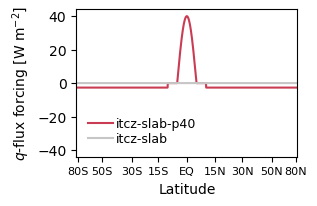

In [4]:
# calculate idealized q_itcz following Eqs. 3 and 4 of ITCZMIP protocol
A_list = [40, 0]  # [W m^-2]
A_labels = [
    "itcz-slab-p40",
    "itcz-slab",
]
A_colors = ["#c93c53","#c6c6c6"]

delPhi = np.pi / 36
phi = np.arange(-np.pi / 2, np.pi / 2, 0.001)  # [lat in rad]
r_earth = 6.314e6

q_itcz = np.zeros((len(A_list), len(phi)))
OHT_itcz = np.zeros((len(A_list), len(phi)))
for a, A in enumerate(A_list):
    q_itcz[a, :] = calc_qflux(phi, A, delPhi)

    for i in range(1, len(phi)):
        OHT_itcz[a, i] = (
            -2 * np.pi * r_earth ** 2
            * integrate.simps(np.cos(phi[: i + 1]) * q_itcz[a, :i+1], x=phi[:i+1])
        )

# plot idealized q_itcz
xticks = np.array([-80, -50, -30, -15, 0, 15, 30, 50, 80])
xticklabels = ["80S", "50S", "30S", "15S", "EQ", "15N", "30N", "50N", "80N"]

cm = 1/2.54  # centimeters to inches
plt.figure(figsize=(8.3*cm, 5.5*cm))
plt.subplot(111)

plt.plot(np.sin(phi), q_itcz[0, :], label=A_labels[0],color=A_colors[0])
plt.plot(np.sin(phi), q_itcz[1, :], label=A_labels[1],color=A_colors[1])

    
plt.xticks(np.sin(np.deg2rad(xticks)), xticklabels, fontsize=8)
plt.xlim([-1, 1])
plt.xlabel("Latitude")
plt.ylabel("$q$-flux forcing [W m$^{-2}]$")
plt.legend(fontsize=9, frameon=False, handletextpad=0.3, labelspacing=0.2)
plt.ylim([-44,44])


plt.tight_layout()

plt.savefig(os.path.join(fig_dir, "fig01.eps"))
#plt.savefig(os.path.join(fig_dir, "fig01.png"),dpi=300)

### Fig. 2: Slab SST and SST difference from control


In [5]:
experiment_list = [
    "itcz-SST",
    "itcz-slab",
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab-p20",
    "itcz-slab-p40",
    "itcz-slab-4xCO2",
    "itcz-slab-4xCO2-m40",
    "itcz-slab-4xCO2-m20",
    "itcz-slab-4xCO2-p20",
    "itcz-slab-4xCO2-p40",
]

exp_ctl_list = experiment_list[1:6]
exp_4xCO2_list = experiment_list[6:11]
exp_pert_list = [x + '-4xCO2response' for x in exp_ctl_list]

# definition of experiments that make up "control" and "response"
exp_plot_lists = {
    "control": exp_ctl_list,
    "response": exp_pert_list,
}

data = {}
data["CESM2"] = imload.load_data("CESM2", experiment_list)

/Users/agp93/Documents/github/width-itcz-mip/itczmip/load.py:23: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_exp = data_exp.rename(dim_dict[model])


In [6]:
myorder=[1,2,0,3,4]
my_exp_ctl_list=[exp_ctl_list[i] for i in myorder]
my_exp_pert_list=[exp_pert_list[i] for i in myorder]
my_exp_plot_lists = {
    "control": my_exp_ctl_list,
    "response": my_exp_pert_list,    
}

### Compute some derived variables for all experiments, CESM2 only

In [7]:
# define dictionary to account for different variable names in different models
vn = imload.define_variable_names()

for model in ["CESM2"]: #model_list:
    for exp, ds in data[model].items():
        imcompute.calc_derived_vars(model, ds)
        imcompute.calc_surf_TOA_fluxes(model, ds)

### Tropical precip (absolute and compared to slab) 

In [8]:
A_labels = [
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab-p20",
    "itcz-slab-p40",
    "itcz-slab",
]

A_colors = ["#3a38c2","#8e7dc6","#cf878a","#c93c53","#c6c6c6"]



In [9]:
disp_labels = [
    "m40",
    "m20",
    "p20",
    "p40",
    "ctl",
]


In [10]:
if "_lline" in A_labels:
    A_labels.index("_lline")

In [11]:
comparison_list = "eqt_heating_ctl"
model = "CESM2"
variable = "pr"

exp_plot_ctl = "itcz-slab"
#exp_plot_pert_list = [exp_ctl_list[i] for i in [0,1,3,4]]
exp_plot_pert_list = ["itcz-slab-m40","itcz-slab-m20","itcz-slab-p20","itcz-slab-p40"]

plot_xlim = 20
tropics_str = '_tropics'

ctl_data = data[model][exp_plot_ctl]
pert_data = [data[model][x] for x in exp_plot_pert_list]

var_plot = vn[model].get(variable)
if var_plot is None:
    var_plot = variable



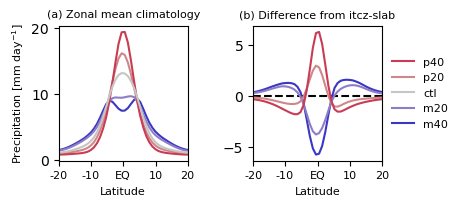

In [12]:
    data_ctl = ctl_data
    data_pert = pert_data
    variable = var_plot
    plot_gm=False
    plot_xlim=plot_xlim
    unit_conv=1.0
    unit_name=""

    #def data_and_delta(data_ctl, data_pert, variable, unit_conv=1.0, unit_name="", plot_xlim=90, plot_gm=True):
    """ Plot line plot of climatologies and differences from data_ctl
    
    Inputs
    ------
    data_ctl: xarray dataset for control experiment data
    data_pert: list of xarray datasets with all perturbation experiments
    variable: string (variable to plot)
    """
    lat_ind = np.abs(data_ctl.lat.values) <= plot_xlim + 2
    sin_lat = np.sin(np.deg2rad(data_ctl.lat.values[lat_ind]))
    if plot_xlim == 90:
        plot_xticks = [-80, -45, -30, -15, 0, 15, 30, 45, 80]
        plot_xtick_labels = ["80S", "45S", "30S", "15S", "EQ", "15N", "30N", "45N", "80N"]
    elif plot_xlim == 30:
        plot_xticks = range(-30, 31, 10)
        plot_xtick_labels = ["30S", "20S", "10S", "EQ", "10N", "20N", "30N"]
    elif plot_xlim == 20:
        #plot_xticks = range(-20, 21, 5)
        plot_xtick_labels = ["20S", "15S", "10S", "5S", "EQ", "5N", "10N", "15N", "20N"]
        plot_xticks = range(-20, 21, 10)
        plot_xtick_labels = ["-20","-10", "EQ", "10", "20"]


    if unit_name == "":
        unit_name = data_ctl[variable].units

    cm = 1/2.54  # centimeters in inches
    fig = plt.figure(figsize=(12*cm, 5.5*cm))
    #fig = plt.figure(figsize=(7.5, 3.2))
    #plt.suptitle(data_ctl.model)
    
    # gs = gridspec.GridSpec(1, 2)
    # ax1 = fig.add_subplot(gs[0])
    # ax2 = fig.add_subplot(gs[1])
    ax1 = plt.subplot(1,2,1)
    ax2 = plt.subplot(1,2,2)
    ax_list = [ax1, ax2]

    for data in data_pert:
        ax1.plot(sin_lat, data[variable].values[lat_ind] * unit_conv, label=data.case)
    ax1.plot(
        sin_lat, data_ctl[variable].values[lat_ind] * unit_conv, label=data_ctl.case
    )
    ax1.set_ylabel(variable + " [" + unit_name + "]",fontsize=8)
    ax1.legend(fontsize=8, labelspacing=0.15, frameon=False)
    ax1.set_title("(a) Zonal mean climatology",fontsize=8)
    ax1.set_xlim(np.sin(np.deg2rad([-plot_xlim, plot_xlim])))
    ax1.set_xticks(np.sin(np.deg2rad(plot_xticks)))
    ax1.set_xticklabels(plot_xtick_labels,fontsize=8)
    ax1.set_xlabel("Latitude",fontsize=8)

    ax2.plot(np.sin(np.deg2rad([-plot_xlim, plot_xlim])), [0, 0], "--k")
    for data in data_pert:
        ax2.plot(
            sin_lat,
            unit_conv
            * (data[variable].values[lat_ind] - data_ctl[variable].values[lat_ind]),
            label=data.case,
        )
        
    ax2.set_title("(b) Difference from " + data_ctl.case,fontsize=8)
    ax2.set_xlim(np.sin(np.deg2rad([-plot_xlim, plot_xlim])))
    ax2.set_xticks(np.sin(np.deg2rad(plot_xticks)))
    ax2.set_xticklabels(plot_xtick_labels,fontsize=8)
    ax2.set_xlabel("Latitude",fontsize=8)
    ax2.legend(fontsize=8, labelspacing=0.15, frameon=False)


    #plt.tight_layout(rect=(0, 0, 1, 0.95))

    #return ax_list
    axes = ax_list
    
    axes[0].set_ylabel("Precipitation [mm day$^{-1}$]",fontsize=8)

    for ax in axes[:]:
        for line in ax.lines:
            lab = line.get_label()
            if lab in A_labels:
                line.set_color(A_colors[A_labels.index(lab)])

    axes[0].legend(fontsize=8, frameon=False)
    axes[1].legend().set_visible(False)
    axes[0].legend().set_visible(False)

    handles, labels = axes[0].get_legend_handles_labels()
    order = [3,2,4,1,0]#[0,1,4,2,3]
    axes[1].legend([handles[idx] for idx in order],[disp_labels[idx] for idx in order],fontsize=8, frameon=False,bbox_to_anchor=(1, .5),loc="center left")

    plt.tight_layout()

    
    plt.savefig(os.path.join(fig_dir, "fig02.eps"))

### Fig. 3: ITCZ Width change


In [13]:
model_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]

In [14]:
experiment_list = [
    "itcz-SST",
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab",
    "itcz-slab-p20",
    "itcz-slab-p40",
]

exp_ctl_list = experiment_list[1:6]

In [15]:
# define dictionary to account for different variable names in different models
vn = imload.define_variable_names()

data = {}
for model in model_list:
    data[model] = imload.load_data(model, experiment_list)


for model in model_list:
    for exp, ds in data[model].items():
        imcompute.calc_derived_vars(model, ds)
        imcompute.calc_surf_TOA_fluxes(model, ds)

/Users/agp93/Documents/github/width-itcz-mip/itczmip/load.py:23: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_exp = data_exp.rename(dim_dict[model])


In [16]:
# define what models to use for scatter plot
model_plot_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]

ds_metrics = imcompute.calc_metrics(data, model_list, experiment_list)


In [17]:
qflx=xr.DataArray.copy(ds_metrics["ITCZ-psi500-extent"])
qflx[0]=0
qflx[1]=-40
qflx[2]=-20
qflx[3]=0
qflx[4]=+20
qflx[5]=+40
# qflx[6]=0
# qflx[7]=-40
# qflx[8]=-20
# qflx[9]=+20
# qflx[10]=+40
# qflx[11]=0
# qflx[12]=-40
# qflx[13]=-20
# qflx[14]=+20
# qflx[15]=+40
qflx.attrs['units']='W/m2'
qflx.attrs['short_name']='Peak q-flux forcing'
ds_metrics["qflx"]=qflx
#qflx

In [18]:

# definition of experiments that make up "control", "4xCO2" and "response"
exp_plot_lists = {
    "control": exp_ctl_list,
#    "4xCO2": exp_4xCO2_list,
#    "response": exp_pert_list,
}

# define list of plots to make (can specifiy variable and either "control", "4xCO2" or "response" for each axis)
# each group of 3 will be put onto one figure (as three subplots)
plot_vars_list = [    
    {"x": {"var": "qflx", "exp": "control"}, "y": {"var": "ITCZ-psi500-extent", "exp": "control"}},
]


Slope and intercept for qflx versus ITCZ-psi500-extent
GFDL-AM2: slope -0.059, intercept: 15.355
CESM1: slope -0.056, intercept: 16.104
CESM2: slope -0.126, intercept: 19.277
Isca: slope -0.073, intercept: 19.514
Slope and intercept for qflx versus ITCZ-psi500-extent
GFDL-AM2: slope -0.059, intercept: -0.006
CESM1: slope -0.056, intercept: 0.438
CESM2: slope -0.126, intercept: 0.932
Isca: slope -0.073, intercept: -0.200


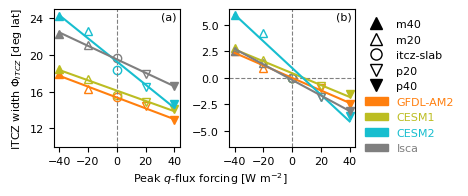

In [19]:
cm = 1/2.54  # centimeters in inches
plt.rcParams['font.size'] = '8'
fig = plt.figure(figsize=(12*cm, 5*cm))
plot_legend = True


plt.subplot(121)

#for p, plot_vars in enumerate(plot_vars_list):
#implot.scatter_models_experiments_againstqflx(ds_metrics, {"var": "qflx", "exp": "control"}, {"var": "ITCZ-psi500-extent", "exp": "control"}, model_plot_list, exp_plot_lists, plot_legend=False,plot_best_fit=True)
#ds_metrics, x_data, y_data, model_plot_list, exp_plot_lists, title='', plot_legend=True, plot_best_fit=False):
x_data = {"var": "qflx", "exp": "control"}
y_data = {"var": "ITCZ-psi500-extent", "exp": "control"}

x_var = "qflx"# x_data["var"]
y_var = "ITCZ-psi500-extent" #y_data["var"]

#x_exp_list = exp_plot_lists[x_data["exp"]]
#y_exp_list = exp_plot_lists[y_data["exp"]]
x_exp_list = exp_ctl_list
y_exp_list = exp_ctl_list


symbols = {
    "itcz-SST": "x",
    "itcz-slab-m40": "^",
    "itcz-slab-m20": "^",
    "itcz-slab": "o",
    "itcz-slab-p20": "v",
    "itcz-slab-p40": "v",
    "itcz-slab-4xCO2-m40": "^",
    "itcz-slab-4xCO2-m20": "^",
    "itcz-slab-4xCO2": "o",
    "itcz-slab-4xCO2-p20": "v",
    "itcz-slab-4xCO2-p40": "v",
    "itcz-slab-m40-4xCO2response": "^",
    "itcz-slab-m20-4xCO2response": "^",
    "itcz-slab-4xCO2response": "o",
    "itcz-slab-p20-4xCO2response": "v",
    "itcz-slab-p40-4xCO2response": "v",
}

fill_style = {
    "itcz-SST": "none",
    "itcz-slab-m40": "full",
    "itcz-slab-m20": "none",
    "itcz-slab": 'none',
    "itcz-slab-p20": "none",
    "itcz-slab-p40": "full",
    "itcz-slab-4xCO2-m40": "full",
    "itcz-slab-4xCO2-m20": "none",
    "itcz-slab-4xCO2": "none",
    "itcz-slab-4xCO2-p20": "none",
    "itcz-slab-4xCO2-p40": "full",
    "itcz-slab-m40-4xCO2response": "full",
    "itcz-slab-m20-4xCO2response": "none",
    "itcz-slab-4xCO2response": "none",
    "itcz-slab-p20-4xCO2response": "none",
    "itcz-slab-p40-4xCO2response": "full",
}


labels = {
    "itcz-SST": "itcz-SST",
    "itcz-slab-m40": "m40",
    "itcz-slab-m20": "m20",
    "itcz-slab": "itcz-slab",
    "itcz-slab-p20": "p20",
    "itcz-slab-p40": "p40",
    "itcz-slab-4xCO2-m40": "itcz-slab-m40",
    "itcz-slab-4xCO2-m20": "itcz-slab-m20",
    "itcz-slab-4xCO2": "itcz-slab",
    "itcz-slab-4xCO2-p20": "itcz-slab-p20",
    "itcz-slab-4xCO2-p40": "itcz-slab-p40",
    "itcz-slab-m40-4xCO2response": "itcz-slab-m40",
    "itcz-slab-m20-4xCO2response": "itcz-slab-m20",
    "itcz-slab-4xCO2response": "itcz-slab",
    "itcz-slab-p20-4xCO2response": "itcz-slab-p20",
    "itcz-slab-p40-4xCO2response": "itcz-slab-p40",
}


colors = {"GFDL-AM2": "tab:orange", "CESM1": "tab:olive", "CESM2-QOBS": "tab:cyan", "CESM2": "tab:cyan", "Isca": "tab:grey"}
line_styles = {"GFDL-AM2": "-", "CESM1": "-", "CESM2-QOBS": "--", "CESM2": "-", "Isca": "-"}
    
# plot data
for model in model_plot_list:
    for x_exp, y_exp in zip(x_exp_list, y_exp_list):
        plt.plot(
            ds_metrics[x_var].sel(experiment=x_exp, model=model),
            ds_metrics[y_var].sel(experiment=y_exp, model=model),
            symbols[x_exp], color=colors[model], fillstyle=fill_style[x_exp]
        )
        
# plot grid lines at zeros (if within plot)
if plt.xlim()[0] < 0 and plt.xlim()[1] > 0:
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)

## plot best fit line
cur_xlim = np.array(plt.xlim())

print("Slope and intercept for %s versus %s" % (x_var, y_var))
for model in model_plot_list:
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(
        ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment"),
        ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment")
    )
    print("%s: slope %.3f, intercept: %.3f" % (model, slope, intercept))

    xdat=ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment")
    line_xlim=np.array([np.min(xdat),np.max(xdat)])
    plt.plot(line_xlim, slope*line_xlim + intercept, line_styles[model] , color= colors[model], linewidth=1.5)

plt.xlim(cur_xlim)

plt.ylabel("ITCZ width $\Phi_{ITCZ}$ [deg lat]")
#plt.xlabel("Peak $q$-flux forcing [W m$^{-2}$]",fontsize=10)
plt.xlabel(" ")
plt.xticks([-40,-20,0,20,40])
plt.yticks([12,16,20,24])
plt.ylim([10,25])

plt.text(1, .98,'(a) ',
     horizontalalignment='right',
     verticalalignment='top',
     transform = plt.gca().transAxes);


plt.subplot(122)

#implot.scatter_models_experiments_slabzeroy(ds_metrics, plot_vars_list[0]["x"], plot_vars_list[0]["y"], model_plot_list, exp_plot_lists, plot_legend=True,plot_best_fit=True)

# plot data
for model in model_plot_list:
    for x_exp, y_exp in zip(x_exp_list, y_exp_list):
        plt.plot(
            ds_metrics[x_var].sel(experiment=x_exp, model=model),
            ds_metrics[y_var].sel(experiment=y_exp, model=model)-ds_metrics[y_var].sel(experiment="itcz-slab", model=model),
            symbols[x_exp], color=colors[model], fillstyle=fill_style[x_exp]
        )
        
# plot grid lines at zeros (if within plot)
if plt.xlim()[0] < 0 and plt.xlim()[1] > 0:
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
if plt.ylim()[0] < 0 and plt.ylim()[1] > 0:
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

## plot best fit line
cur_xlim = np.array(plt.xlim())

print("Slope and intercept for %s versus %s" % (x_var, y_var))
for model in model_plot_list:
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(
        ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment"),
#        ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment")
        ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment")-ds_metrics[y_var].sel(experiment="itcz-slab", model=model)
    )

    print("%s: slope %.3f, intercept: %.3f" % (model, slope, intercept))

    xdat=ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment")
    line_xlim=np.array([np.min(xdat),np.max(xdat)])
    plt.plot(line_xlim, slope*line_xlim + intercept, line_styles[model] , color= colors[model], linewidth=1.5)

plt.xlim(cur_xlim)

# create legend items to label experiments by symbol
leg_handles = []
symbol_kwargs = dict(color="w", markerfacecolor="k", markersize=8, markeredgecolor="k")
for exp in x_exp_list:
    leg_handles.append(
        Line2D([0], [0], marker=symbols[exp], label=labels[exp], fillstyle=fill_style[exp], **symbol_kwargs)
    )

# create legend items to label models by color
for model in model_plot_list:
    leg_handles.append(Patch(color=colors[model], label=model))

# create legend
leg = plt.legend(
    #handles=leg_handles, fontsize=10, frameon=False, bbox_to_anchor=(1, 1)
    handles=leg_handles, fontsize=8, frameon=False, bbox_to_anchor=(1, 1)
)

# modify color of model labels to match handles
for text in leg.get_texts():
    if text.get_text() in model_plot_list:
        text.set_color(colors[text.get_text()])

plt.xticks([-40,-20,0,20,40])
plt.yticks([-5,-2.5,0,2.5,5])
plt.ylim([-6.5,6.5])

plt.text(1, .98,'(b) ',
     horizontalalignment='right',
     verticalalignment='top',
     transform = plt.gca().transAxes)

fig.text(0.45,0.04,"Peak $q$-flux forcing [W m$^{-2}$]",va="bottom",ha="center")

plt.tight_layout()


plt.savefig(os.path.join(fig_dir, "fig03.eps"))

### Figure 4

In [20]:
model_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]

experiment_list = [
    "itcz-SST",
    "itcz-slab",
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab-p20",
    "itcz-slab-p40",
    "itcz-slab-4xCO2",
    "itcz-slab-4xCO2-m40",
    "itcz-slab-4xCO2-m20",
    "itcz-slab-4xCO2-p20",
    "itcz-slab-4xCO2-p40",
]

exp_ctl_list = experiment_list[1:6]
exp_4xCO2_list = experiment_list[6:11]
exp_pert_list = [x + '-4xCO2response' for x in exp_ctl_list]

# definition of experiments that make up "control" and "response"
exp_plot_lists = {
    "control": exp_ctl_list,
    "response": exp_pert_list,
}

data = {}
for model in model_list:
    data[model] = imload.load_data(model, experiment_list)

/Users/agp93/Documents/github/width-itcz-mip/itczmip/load.py:23: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_exp = data_exp.rename(dim_dict[model])


In [21]:
experiment_list = [
    "itcz-SST",
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab",
    "itcz-slab-p20",
    "itcz-slab-p40",
    "itcz-slab-4xCO2",
    "itcz-slab-4xCO2-m40",
    "itcz-slab-4xCO2-m20",
    "itcz-slab-4xCO2-p20",
    "itcz-slab-4xCO2-p40",
]

exp_ctl_list = experiment_list[1:6]
exp_4xCO2_list = experiment_list[6:11]
exp_pert_list = [x + '-4xCO2response' for x in exp_ctl_list]

# definition of experiments that make up "control" and "response"
exp_plot_lists = {
    "control": exp_ctl_list,
    "response": exp_pert_list,
}

In [22]:
A_list = [40, 0]  # [W m^-2]
A_labels = [
    "itcz-slab-p40",
    "itcz-slab",
]
A_colors = ["#c93c53","#c6c6c6"]


Slope and intercept for ITCZ-psi500-extent versus ts-gm
GFDL-AM2: slope 0.432, intercept: 279.230
CESM1: slope 0.308, intercept: 280.651
CESM2: slope 0.290, intercept: 280.811
Isca: slope 0.092, intercept: 284.240


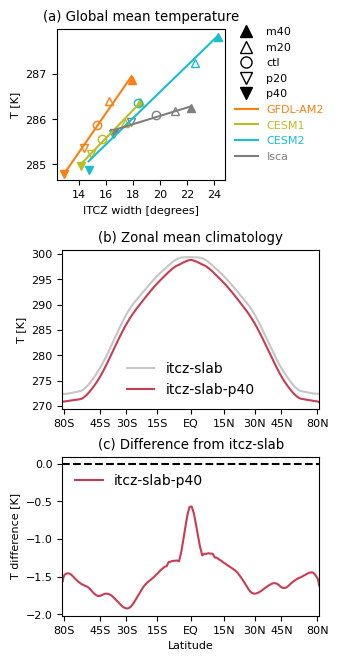

In [23]:
# cm = 1/2.54  # centimeters in inches
# plt.figure(figsize=(8.3*cm, 18*cm))


cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(8.3*cm, 3*5.5*cm),layout="constrained")#,constrained_layout=True)

#plt.rcParams['figure.constrained_layout.use'] = True

subfigs = fig.subfigures(2,1,height_ratios=[1,2])


#### bottom 2 panels 

model_list = ["CESM2"]
model = model_list[0]

comparison_list = "eqt_heating_ctl"
variable = "ts"


exp_plot_ctl = exp_ctl_list[2]
exp_plot_pert_list = [exp_ctl_list[-1]]



plot_xlim = 90
tropics_str = ''

ctl_data = data[model][exp_plot_ctl]
pert_data = [data[model][x] for x in exp_plot_pert_list]

var_plot = vn[model].get(variable)
if var_plot is None:
    var_plot = variable

    
#axes = implot.data_and_delta(ctl_data, pert_data, var_plot, plot_gm=False, plot_xlim=plot_xlim)    
#def data_and_delta(data_ctl, data_pert, variable, unit_conv=1.0, unit_name="", plot_xlim=90, plot_gm=True):
data_ctl = ctl_data
data_pert = pert_data
unit_conv=1.0
unit_name=""
""" Plot line plot of climatologies and differences from data_ctl

Inputs
------
data_ctl: xarray dataset for control experiment data
data_pert: list of xarray datasets with all perturbation experiments
variable: string (variable to plot)
"""
lat_ind = np.abs(data_ctl.lat.values) <= plot_xlim + 2
sin_lat = np.sin(np.deg2rad(data_ctl.lat.values[lat_ind]))

plot_xticks = [-80, -45, -30, -15, 0, 15, 30, 45, 80]
plot_xtick_labels = ["80S", "45S", "30S", "15S", "EQ", "15N", "30N", "45N", "80N"]

if unit_name == "":
    unit_name = data_ctl[var_plot].units

#plt.suptitle(data_ctl.model)

gs = gridspec.GridSpec(2,1,figure=subfigs[1])
ax1 = subfigs[1].add_subplot(gs[0])
ax2 = subfigs[1].add_subplot(gs[1])

#ax1 = subfigs[1].subplot(211)

for data_local in data_pert:
    ax1.plot(sin_lat, data_local[var_plot].values[lat_ind] * unit_conv, label=data_local.case)
ax1.plot(
    sin_lat, data_ctl[var_plot].values[lat_ind] * unit_conv, label=data_ctl.case
)
ax1.set_ylabel(variable + " [" + unit_name + "]")
ax1.legend(fontsize=8, labelspacing=0.15, frameon=False)
ax1.set_title("(b) Zonal mean climatology")
ax1.set_xlim(np.sin(np.deg2rad([-plot_xlim, plot_xlim])))
ax1.set_xticks(np.sin(np.deg2rad(plot_xticks)))
ax1.set_xticklabels(plot_xtick_labels,fontsize=8)
#ax1.set_xlabel("Latitude [degN]")

#ax2 = subfigs[1].subplot(212)


ax2.plot(np.sin(np.deg2rad([-plot_xlim, plot_xlim])), [0, 0], "--k")
for data_local in data_pert:
    ax2.plot(
        sin_lat,
        unit_conv
        * (data_local[var_plot].values[lat_ind] - data_ctl[var_plot].values[lat_ind]),
        label=data_local.case,
    )

ax2.set_title("(c) Difference from " + data_ctl.case)
ax2.set_xlim(np.sin(np.deg2rad([-plot_xlim, plot_xlim])))
ax2.set_xticks(np.sin(np.deg2rad(plot_xticks)))
ax2.set_xticklabels(plot_xtick_labels,fontsize=8)
ax2.set_xlabel("Latitude")
ax2.legend(fontsize=8, labelspacing=0.15, frameon=False)


#plt.tight_layout(rect=(0, 0, 1, 0.95))

ax_list = [ax1, ax2]

#return ax_list
axes=ax_list
    
axes[0].set_ylabel("T [K]")
#axes[0].set_xlabel("Latitude")
axes[1].set_ylabel("T difference [K]")


for ax in axes[:]:
    for line in ax.lines:
        lab = line.get_label()
        if lab in A_labels:
            line.set_color(A_colors[A_labels.index(lab)])

handles, labels = axes[0].get_legend_handles_labels()
order = [1,0]
axes[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=10, frameon=False)
handles, labels = axes[1].get_legend_handles_labels()
order = [0]
axes[1].legend([handles[idx] for idx in order],[labels[idx] for idx in order],fontsize=10, frameon=False, bbox_to_anchor=(0, .85), loc="center left")

#plt.tight_layout()

#gs.tight_layout(subfigs[1])

### first panel 


gs2 = gridspec.GridSpec(1,1,figure=subfigs[0])
ax0 = subfigs[0].add_subplot(gs2[0])

#ax0 = subfigs[0].add_subplot(111)

plot_vars = {"x": {"var": "ITCZ-psi500-extent", "exp": "control"}, "y": {"var": "ts-gm", "exp": "control"}}

#implot.scatter_models_experiments(ds_metrics, plot_vars["x"], plot_vars["y"], model_plot_list, exp_plot_lists, plot_legend=True,plot_best_fit=True)
x_data = plot_vars["x"]
y_data = plot_vars["y"]
title=''
plot_legend=True
plot_best_fit=True
#def scatter_models_experiments(ds_metrics, x_data, y_data, model_plot_list, exp_plot_lists, title='', plot_legend=True, plot_best_fit=False):

symbols = {
    "itcz-SST": "x",
    "itcz-slab-m40": "^",
    "itcz-slab-m20": "^",
    "itcz-slab": "o",
    "itcz-slab-p20": "v",
    "itcz-slab-p40": "v",
}

fill_style = {
    "itcz-SST": "none",
    "itcz-slab-m40": "full",
    "itcz-slab-m20": "none",
    "itcz-slab": 'none',
    "itcz-slab-p20": "none",
    "itcz-slab-p40": "full",
}


labels = {
    "itcz-slab-m40": "m40",
    "itcz-slab-m20": "m20",
    "itcz-slab": "ctl",
    "itcz-slab-p20": "p20",
    "itcz-slab-p40": "p40",
}



colors = {"GFDL-AM2": "tab:orange", "CESM1": "tab:olive", "CESM2-QOBS": "tab:cyan", "CESM2": "tab:cyan", "Isca": "tab:grey"}
line_styles = {"GFDL-AM2": "-", "CESM1": "-", "CESM2-QOBS": "--", "CESM2": "-", "Isca": "-"}

x_var = x_data["var"]
y_var = y_data["var"]

x_exp_list = exp_plot_lists[x_data["exp"]]
y_exp_list = exp_plot_lists[y_data["exp"]]


ax0.set_title(title)
ax0.set_xlabel("%s\n%s [%s]" % (x_data["exp"], ds_metrics[x_var].attrs["short_name"], ds_metrics[x_var].attrs["units"]))
ax0.set_ylabel("%s\n%s [%s]" % (y_data["exp"], ds_metrics[y_var].attrs["short_name"], ds_metrics[y_var].attrs["units"]))

# plot data
for model in model_plot_list:
    for x_exp, y_exp in zip(x_exp_list, y_exp_list):
        ax0.plot(
            ds_metrics[x_var].sel(experiment=x_exp, model=model),
            ds_metrics[y_var].sel(experiment=y_exp, model=model),
            symbols[x_exp], color=colors[model], fillstyle=fill_style[x_exp]
        )

# plot grid lines at zeros (if within plot)
if ax0.get_xlim()[0] < 0 and ax0.get_xlim()[1] > 0:
    ax0.axvline(0, color='grey', linestyle='--', linewidth=0.8)
if ax0.get_ylim()[0] < 0 and ax0.get_ylim()[1] > 0:
    ax0.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# compute and plot linear best fit
if plot_best_fit:
    cur_xlim = np.array(plt.xlim())

    print("Slope and intercept for %s versus %s" % (x_var, y_var))
    for model in model_plot_list:
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(
            ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment"),
            ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment")
        )
        print("%s: slope %.3f, intercept: %.3f" % (model, slope, intercept))

        xdat=ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment")
        line_xlim=np.array([np.min(xdat),np.max(xdat)])
        ax0.plot(line_xlim, slope*line_xlim + intercept, line_styles[model] , color= colors[model], linewidth=1.5)

    ax0.set_xlim(cur_xlim)

plt.xticks([14,16,18,20,22,24])


if plot_legend:
    # create legend items to label experiments by symbol
    leg_handles = []
    symbol_kwargs = dict(color="k", markerfacecolor="k", markersize=8, linestyle="none")
    for exp in x_exp_list:
        leg_handles.append(
            Line2D([0], [0], marker=symbols[exp], label=labels[exp],  fillstyle=fill_style[exp], **symbol_kwargs)
        )

    # create legend items to label models by color
    for model in model_plot_list:
#            leg_handles.append(Patch(color=colors[model], label=model))
        leg_handles.append(
            Line2D([0], [0], color=colors[model], label=model,  linestyle=line_styles[model])
        )

    # create legend
    leg = ax0.legend(
        handles=leg_handles, fontsize=8, frameon=False, bbox_to_anchor=(1, 1.08)
    )

    # modify color of model labels to match handles
    for text in leg.get_texts():
        if text.get_text() in model_plot_list:
            text.set_color(colors[text.get_text()])

ax0.set_title('(a) Global mean temperature')
#ax0.set_xlabel('Control ITCZ width [degrees]')
ax0.set_xlabel('ITCZ width [degrees]')
ax0.set_ylabel('T [K]')

#plt.draw()

fig.savefig(os.path.join(fig_dir, "fig04.eps"))
#fig.savefig(os.path.join(fig_dir, "fig04.png"))

### Figure 5

### Specify what data to load, and load it

In [24]:
disp_labels = [
    "ctl",
    "p40"
]

In [25]:
model_list = ["CESM2"]

experiment_list = [
    "itcz-slab",
    "itcz-slab-p40",
]

exp_ctl_list = experiment_list[1:6]
#exp_4xCO2_list = experiment_list[6:11]
#exp_pert_list = [x + '-4xCO2response' for x in exp_ctl_list]

# definition of experiments that make up "control" and "response"
exp_plot_lists = {
    "control": exp_ctl_list#,
#    "response": exp_pert_list,
}

data = {}
for model in model_list:
    data[model] = imload.load_data(model, experiment_list)

/Users/agp93/Documents/github/width-itcz-mip/itczmip/load.py:23: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_exp = data_exp.rename(dim_dict[model])


### Compute some derived variables for all models/experiments

In [26]:
# define dictionary to account for different variable names in different models
vn = imload.define_variable_names()

for model in model_list:
    for exp, ds in data[model].items():
        imcompute.calc_derived_vars(model, ds)
        imcompute.calc_surf_TOA_fluxes(model, ds)

### Compute circulation diagnostics (e.g. ITCZ width, strength, area, etc.) and their response to 4xCO2

In [27]:
# calculate various metrics for each model and experiment and
# save to an xarray dataset with dimensions model versus experiment
ds_metrics = imcompute.calc_metrics(data, model_list, experiment_list)
#ds_metrics = imcompute.calc_4xCO2_response(ds_metrics, exp_ctl_list)

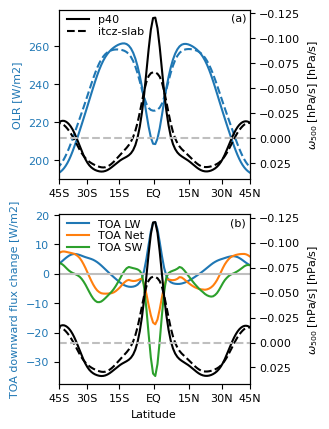

In [28]:

plt.rcParams['font.size'] = '8'

cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(8.3*cm, 11*cm))


model = "CESM2"

exp = "itcz-slab-p40"

sin_lat = np.sin(np.deg2rad(data[model][exp].lat.values))

plot_xlim = 45

plot_xticks = [ -45, -30, -15, 0, 15, 30, 45 ]
plot_xtick_labels = ["45S", "30S", "15S", "EQ", "15N", "30N", "45N"]


lat_ind = np.abs(data[model]["itcz-slab-p40"].lat.values) <= plot_xlim + 2






plt.subplot(211)


variable ="toa_lw"

plt.plot(sin_lat[lat_ind], -1 * data[model][exp][variable].values[lat_ind], label="p40")
plt.plot(sin_lat[lat_ind], -1 * data[model]["itcz-slab"][variable].values[lat_ind],"--", label="ctl", color="C0")
#plt.plot(sin_lat[lat_ind], -1 * (data[model][exp][variable].values[lat_ind]-data[model]["itcz-slab"][variable].values[lat_ind]), label=data[model]["itcz-slab-p40"].case)
#plt.plot(np.sin(np.deg2rad([-plot_xlim, plot_xlim])), [0, 0], "-",color=".75")


#plt.ylabel("Toa Net rad m40 - slab [W/m2]",color="C0")
plt.ylabel("OLR [W/m2]",color="C0")
#plt.legend(fontsize=8, labelspacing=0.15, frameon=False)
#plt.title("Difference from control")
plt.xlim(np.sin(np.deg2rad([-plot_xlim, plot_xlim])))
plt.ylim([190,279])
plt.xticks(np.sin(np.deg2rad(plot_xticks)),labels=plot_xtick_labels)
#plt.xticklabels(plot_xtick_labels)
#plt.xlabel("Latitude [degN]")
plt.tick_params(axis='y', labelcolor="C0")

ax = plt.gca()



ax2 = ax.twinx() 

ax2.plot(sin_lat, data[model][exp]["wa500"].values, label="p40", color="k")

#ax2.plot(sin_lat, data[model]["itcz-slab"]["wa500"].values,  "--", label="itcz-slab w500", color="k")
ax2.plot(sin_lat, data[model]["itcz-slab"]["wa500"].values,  "--", label="itcz-slab", color="k")


#ax2.plot(sin_lat, data[model][exp]["wa500"].values, label=exp + " w500", color="k")
ax2.set_ylabel('$\omega_{500}$ [hPa/s] [hPa/s]') 
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.plot(np.sin(np.deg2rad([-plot_xlim, plot_xlim])), [0, 0], "--",color=".75")

#ax2.legend(fontsize=8, labelspacing=0.15, frameon=False,loc="lower center")
ax2.legend(fontsize=8, labelspacing=0.15, frameon=False,loc=2, bbox_to_anchor = (-.01,1.03))

#plt.title(model + " OLR for p40 and " + exp + " $\omega_{500}$")

plt.text(1, .98,'(a) ',
     horizontalalignment='right',
     verticalalignment='top',
     transform = plt.gca().transAxes)


plt.subplot(212)

#plt.plot(sin_lat[lat_ind], data[model][exp][variable].values[lat_ind], label=data[model][exp].case)
variable ="toa_lw"
plt.plot(sin_lat[lat_ind],  (data[model][exp][variable].values[lat_ind]-data[model]["itcz-slab"][variable].values[lat_ind]), label="TOA LW")
variable ="toa_net"
plt.plot(sin_lat[lat_ind],  (data[model][exp][variable].values[lat_ind]-data[model]["itcz-slab"][variable].values[lat_ind]), label="TOA Net")
variable ="toa_sw"
plt.plot(sin_lat[lat_ind],  (data[model][exp][variable].values[lat_ind]-data[model]["itcz-slab"][variable].values[lat_ind]), label="TOA SW")

plt.plot(np.sin(np.deg2rad([-plot_xlim, plot_xlim])), [0, 0], "-",color=".75")


#plt.ylabel("Toa Net rad m40 - slab [W/m2]",color="C0")
plt.ylabel("TOA downward flux change [W/m2]",color="C0")
#plt.legend(fontsize=8, labelspacing=0.15, frameon=False, loc="upper right")

#plt.legend(fontsize=8, labelspacing=0.15, frameon=False, loc="upper right", bbox_to_anchor = (1.025,1.025))
plt.legend(fontsize=8, labelspacing=0.15, frameon=False, loc="upper left", bbox_to_anchor = (-.01,1.03))

#plt.title("Difference from control")
plt.xlim(np.sin(np.deg2rad([-plot_xlim, plot_xlim])))
plt.xticks(np.sin(np.deg2rad(plot_xticks)),labels=plot_xtick_labels)
#plt.xticklabels(plot_xtick_labels)
plt.xlabel("Latitude")
plt.tick_params(axis='y', labelcolor="C0")

ax = plt.gca()



ax2 = ax.twinx() 
ax2.plot(sin_lat, data[model]["itcz-slab"]["wa500"].values,  "--", label="itcz-slab w500", color="k")

ax2.plot(sin_lat, data[model][exp]["wa500"].values, label=exp + " w500", color="k")
ax2.set_ylabel('$\omega_{500}$ [hPa/s] [hPa/s]') 
ax2.set_ylim(ax2.get_ylim()[::-1])
ax2.plot(np.sin(np.deg2rad([-plot_xlim, plot_xlim])), [0, 0], "--",color=".75")

#ax2.legend(fontsize=8, labelspacing=0.15, frameon=False)

#plt.title(model + " TOA change for p40 and " + exp + " $\omega_{500}$")

plt.text(1, .98,'(b) ',
     horizontalalignment='right',
     verticalalignment='top',
     transform = plt.gca().transAxes)

plt.tight_layout()


plt.savefig(os.path.join(fig_dir, "fig05.eps"))

### Figure 6

In [29]:
model_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]

experiment_list = [
    "itcz-SST",
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab",
    "itcz-slab-p20",
    "itcz-slab-p40",
]

exp_ctl_list = experiment_list[1:6]
#exp_4xCO2_list = experiment_list[6:11]
#exp_pert_list = [x + '-4xCO2response' for x in exp_ctl_list]

# definition of experiments that make up "control" and "response"
exp_plot_lists = {
    "control": exp_ctl_list#,
#    "response": exp_pert_list,
}

data = {}
for model in model_list:
    data[model] = imload.load_data(model, experiment_list)

/Users/agp93/Documents/github/width-itcz-mip/itczmip/load.py:23: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_exp = data_exp.rename(dim_dict[model])


### Compute some derived variables for all models/experiments

In [30]:
# define dictionary to account for different variable names in different models
vn = imload.define_variable_names()

for model in model_list:
    for exp, ds in data[model].items():
        imcompute.calc_derived_vars(model, ds)
        imcompute.calc_surf_TOA_fluxes(model, ds)

In [31]:
ds_metrics = imcompute.calc_metrics(data, model_list, experiment_list)


In [32]:
# define what models to use for scatter plot
model_plot_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]
model_list_name = "_".join(model_plot_list)

# define x and y variables for scatter plot, for two subplots
plot_vars_1 = {"x": {"var": "ITCZ-psi500-extent", "exp": "control"}, "y": {"var": "ITCZ-psi500-strength", "exp": "control"}}
plot_vars_2 = {"x": {"var": "ITCZ-psi500-extent-rel-norm", "exp": "response"}, "y": {"var": "ITCZ-psi500-strength-rel-norm", "exp": "response"}}




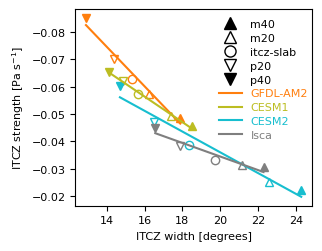

In [33]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(8.3*cm, 6.5*cm))
plt.subplot(111)



[x_data, y_data] = [plot_vars_1["x"], plot_vars_1["y"]]
title=''
plot_best_fit=True
plot_legend=True

symbols = {
    "itcz-SST": "x",
    "itcz-slab-m40": "^",
    "itcz-slab-m20": "^",
    "itcz-slab": "o",
    "itcz-slab-p20": "v",
    "itcz-slab-p40": "v"
}

fill_style = {
    "itcz-SST": "none",
    "itcz-slab-m40": "full",
    "itcz-slab-m20": "none",
    "itcz-slab": 'none',
    "itcz-slab-p20": "none",
    "itcz-slab-p40": "full"
}


labels = {
    "itcz-SST": "itcz-SST",
    "itcz-slab-m40": "m40",
    "itcz-slab-m20": "m20",
    "itcz-slab": "itcz-slab",
    "itcz-slab-p20": "p20",
    "itcz-slab-p40": "p40"
}

colors = {"GFDL-AM2": "tab:orange", "CESM1": "tab:olive", "CESM2-QOBS": "tab:cyan", "CESM2": "tab:cyan", "Isca": "tab:grey"}
line_styles = {"GFDL-AM2": "-", "CESM1": "-", "CESM2-QOBS": "--", "CESM2": "-", "Isca": "-"}

x_var = x_data["var"]
y_var = y_data["var"]

x_exp_list = exp_plot_lists[x_data["exp"]]
y_exp_list = exp_plot_lists[y_data["exp"]]

plt.xlabel("%s\n%s [%s]" % (x_data["exp"], ds_metrics[x_var].attrs["short_name"], ds_metrics[x_var].attrs["units"]),fontsize=8)
plt.ylabel("%s\n%s [%s]" % (y_data["exp"], ds_metrics[y_var].attrs["short_name"], ds_metrics[y_var].attrs["units"]),fontsize=8)

# plot data
for model in model_plot_list:
    for x_exp, y_exp in zip(x_exp_list, y_exp_list):
        plt.plot(
            ds_metrics[x_var].sel(experiment=x_exp, model=model),
            ds_metrics[y_var].sel(experiment=y_exp, model=model),
            symbols[x_exp], color=colors[model], fillstyle=fill_style[x_exp]
        )

# plot grid lines at zeros (if within plot)
if plt.xlim()[0] < 0 and plt.xlim()[1] > 0:
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
if plt.ylim()[0] < 0 and plt.ylim()[1] > 0:
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# compute and plot linear best fit
if plot_best_fit:
    cur_xlim = np.array(plt.xlim())

    #print("Slope and intercept for %s versus %s" % (x_var, y_var))
    for model in model_plot_list:
        slope, intercept, rvalue, pvalue, stderr = stats.linregress(
            ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment"),
            ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment")
        )
        #print("%s: slope %.3f, intercept: %.3f" % (model, slope, intercept))

        xdat=ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment")
        line_xlim=np.array([np.min(xdat),np.max(xdat)])
        plt.plot(line_xlim, slope*line_xlim + intercept, line_styles[model] , color= colors[model], linewidth=1.5)

        #plt.plot(line_xlim, slope*line_xlim + intercept, '-' + "k")
#             plt.plot(xdat,ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment"),
#                      color= colors[model], linestyle="solid", zorder=0, linewidth=0.5)

        #plt.plot(cur_xlim, slope*cur_xlim + intercept, '-' + colors[model])

    plt.xlim(cur_xlim)


if plot_legend:
    # create legend items to label experiments by symbol
    leg_handles = []
    symbol_kwargs = dict(color="k", markerfacecolor="k", markersize=8, linestyle="none")
    for exp in x_exp_list:
        leg_handles.append(
            Line2D([0], [0], marker=symbols[exp], label=labels[exp],  fillstyle=fill_style[exp], **symbol_kwargs)
        )

    # create legend items to label models by color
    for model in model_plot_list:
#            leg_handles.append(Patch(color=colors[model], label=model))
        leg_handles.append(
            Line2D([0], [0], color=colors[model], label=model,  linestyle=line_styles[model])
        )

    # create legend
    leg = plt.legend(
        handles=leg_handles, fontsize=8, frameon=False, labelspacing=0.35, bbox_to_anchor=(1.025, 1),loc=1
    )

    # modify color of model labels to match handles
    for text in leg.get_texts():
        if text.get_text() in model_plot_list:
            text.set_color(colors[text.get_text()])


plt.tick_params(labelsize=8)

plt.xlabel('ITCZ width [degrees]',fontsize=8)
plt.ylabel('ITCZ strength [Pa s$^{-1}$]',fontsize=8)
plt.gca().invert_yaxis()


plt.tight_layout()

plt.savefig(os.path.join(fig_dir, "fig06.eps"))

### Figure 9


### Specify what data to load, and load it

In [34]:
model_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]

experiment_list = [
    "itcz-SST",
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab",
    "itcz-slab-p20",
    "itcz-slab-p40",
    "itcz-slab-4xCO2",
    "itcz-slab-4xCO2-m40",
    "itcz-slab-4xCO2-m20",
    "itcz-slab-4xCO2-p20",
    "itcz-slab-4xCO2-p40",
]

exp_ctl_list = experiment_list[1:6]
exp_4xCO2_list = experiment_list[6:11]
exp_pert_list = [x + '-4xCO2response' for x in exp_ctl_list]

# definition of experiments that make up "control" and "response"
exp_plot_lists = {
    "control": exp_ctl_list,
    "response": exp_pert_list,
}

data = {}
for model in model_list:
    data[model] = imload.load_data(model, experiment_list)

/Users/agp93/Documents/github/width-itcz-mip/itczmip/load.py:23: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_exp = data_exp.rename(dim_dict[model])


### Compute some derived variables for all models/experiments

In [35]:
# define dictionary to account for different variable names in different models
vn = imload.define_variable_names()

for model in model_list:
    for exp, ds in data[model].items():
        imcompute.calc_derived_vars(model, ds)
        imcompute.calc_surf_TOA_fluxes(model, ds)

### Compute circulation diagnostics (e.g. ITCZ width, strength, area, etc.) and their response to 4xCO2

In [36]:
# calculate various metrics for each model and experiment and
# save to an xarray dataset with dimensions model versus experiment
ds_metrics = imcompute.calc_metrics(data, model_list, experiment_list)
ds_metrics = imcompute.calc_4xCO2_response(ds_metrics, exp_ctl_list)

In [37]:
model_plot_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]
model_list_name = "_".join(model_plot_list)
exp_longnames = {"control": "Control climatologies",
                "response": "Response to 4xCO2"}

Slope and intercept for ITCZ-psi500-extent versus ITCZ-psi500-extent
GFDL-AM2: slope -0.159, intercept: 2.213
CESM1: slope 0.002, intercept: 0.039
CESM2: slope -0.465, intercept: 9.094
Isca: slope -0.486, intercept: 9.457
Slope and intercept for ITCZ-psi500-extent versus ts-gm
GFDL-AM2: slope 0.011, intercept: 3.563
CESM1: slope 0.325, intercept: -1.287
CESM2: slope -0.067, intercept: 4.644
Isca: slope 0.103, intercept: 5.028


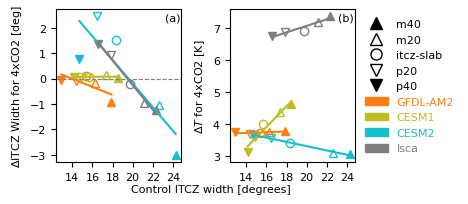

In [38]:
cm = 1/2.54  # centimeters in inches
plt.rcParams['font.size'] = '8'
fig = plt.figure(figsize=(12*cm, 5*cm))

symbols = {
    "itcz-slab-m40": "^",
    "itcz-slab-m20": "^",
    "itcz-slab": "o",
    "itcz-slab-p20": "v",
    "itcz-slab-p40": "v",
}

fill_style = {
    "itcz-slab-m40": "full",
    "itcz-slab-m20": "none",
    "itcz-slab": 'none',
    "itcz-slab-p20": "none",
    "itcz-slab-p40": "full",
}


labels = {
    "itcz-slab-m40": "m40",
    "itcz-slab-m20": "m20",
    "itcz-slab": "itcz-slab",
    "itcz-slab-p20": "p20",
    "itcz-slab-p40": "p40",
}

colors = {"GFDL-AM2": "tab:orange", "CESM1": "tab:olive", "CESM2-QOBS": "tab:cyan", "CESM2": "tab:cyan", "Isca": "tab:grey"}
line_styles = {"GFDL-AM2": "-", "CESM1": "-", "CESM2-QOBS": "--", "CESM2": "-", "Isca": "-"}



plt.subplot(121)


plot_vars = {"x": {"var": "ITCZ-psi500-extent", "exp": "control"}, "y": {"var": "ITCZ-psi500-extent", "exp": "response"}}
#scatter_models_experiments(ds_metrics, plot_vars["x"], plot_vars["y"], model_plot_list, exp_plot_lists, plot_legend=False,plot_best_fit=True)
#scatter_models_experiments(ds_metrics, x_data, y_data, model_plot_list, exp_plot_lists, title='', plot_legend=True, plot_best_fit=False):
[x_data, y_data] = [plot_vars["x"], plot_vars["y"]]

x_var = x_data["var"]
y_var = y_data["var"]

x_exp_list = exp_plot_lists[x_data["exp"]]
y_exp_list = exp_plot_lists[y_data["exp"]]

# plot data
for model in model_plot_list:
    for x_exp, y_exp in zip(x_exp_list, y_exp_list):
        plt.plot(
            ds_metrics[x_var].sel(experiment=x_exp, model=model),
            ds_metrics[y_var].sel(experiment=y_exp, model=model),
            symbols[x_exp], color=colors[model], fillstyle=fill_style[x_exp]
        )
            
# plot grid lines at zeros (if within plot)
if plt.xlim()[0] < 0 and plt.xlim()[1] > 0:
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
if plt.ylim()[0] < 0 and plt.ylim()[1] > 0:
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# compute and plot linear best fit
cur_xlim = np.array(plt.xlim())

print("Slope and intercept for %s versus %s" % (x_var, y_var))
for model in model_plot_list:
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(
        ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment"),
        ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment")
    )
    print("%s: slope %.3f, intercept: %.3f" % (model, slope, intercept))

    xdat=ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment")
    line_xlim=np.array([np.min(xdat),np.max(xdat)])
    plt.plot(line_xlim, slope*line_xlim + intercept, line_styles[model] , color= colors[model], linewidth=1.5)

    #plt.plot(line_xlim, slope*line_xlim + intercept, '-' + "k")
#             plt.plot(xdat,ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment"),
#                      color= colors[model], linestyle="solid", zorder=0, linewidth=0.5)

    #plt.plot(cur_xlim, slope*cur_xlim + intercept, '-' + colors[model])

plt.xlim(cur_xlim)
plt.xticks([14,16,18,20,22,24])
#plt.ylabel('ITCZ width response\nto 4xCO2 [deg]')
plt.yticks([-3,-2,-1,0,1,2])
plt.ylabel('$\Delta$ITCZ Width for 4xCO2 [deg]')
#plt.title("ITCZ versus jet position")
plt.text(.99,.98,'(a)',horizontalalignment='right',verticalalignment='top', transform=plt.gca().transAxes)



plt.subplot(122)

plot_vars = {"x": {"var": "ITCZ-psi500-extent", "exp": "control"}, "y": {"var": "ts-gm", "exp": "response"}}
#scatter_models_experiments(ds_metrics, plot_vars["x"], plot_vars["y"], model_plot_list, exp_plot_lists,plot_best_fit=True)
[x_data, y_data] = [plot_vars["x"], plot_vars["y"]]

x_var = x_data["var"]
y_var = y_data["var"]

x_exp_list = exp_plot_lists[x_data["exp"]]
y_exp_list = exp_plot_lists[y_data["exp"]]

# plot data
for model in model_plot_list:
    for x_exp, y_exp in zip(x_exp_list, y_exp_list):
        plt.plot(
            ds_metrics[x_var].sel(experiment=x_exp, model=model),
            ds_metrics[y_var].sel(experiment=y_exp, model=model),
            symbols[x_exp], color=colors[model], fillstyle=fill_style[x_exp]
        )

        # plot grid lines at zeros (if within plot)
if plt.xlim()[0] < 0 and plt.xlim()[1] > 0:
    plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
if plt.ylim()[0] < 0 and plt.ylim()[1] > 0:
    plt.axhline(0, color='grey', linestyle='--', linewidth=0.8)

# compute and plot linear best fit
cur_xlim = np.array(plt.xlim())

print("Slope and intercept for %s versus %s" % (x_var, y_var))
for model in model_plot_list:
    slope, intercept, rvalue, pvalue, stderr = stats.linregress(
        ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment"),
        ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment")
    )
    print("%s: slope %.3f, intercept: %.3f" % (model, slope, intercept))

    xdat=ds_metrics[x_var].sel(experiment=x_exp_list, model=model).dropna(dim="experiment")
    line_xlim=np.array([np.min(xdat),np.max(xdat)])
    plt.plot(line_xlim, slope*line_xlim + intercept, line_styles[model] , color= colors[model], linewidth=1.5)

    #plt.plot(line_xlim, slope*line_xlim + intercept, '-' + "k")
#             plt.plot(xdat,ds_metrics[y_var].sel(experiment=y_exp_list, model=model).dropna(dim="experiment"),
#                      color= colors[model], linestyle="solid", zorder=0, linewidth=0.5)

    #plt.plot(cur_xlim, slope*cur_xlim + intercept, '-' + colors[model])

plt.xlim(cur_xlim)
#plt.ylabel('Global-mean surface temp\nresponse to 4xCO2 [K]')
plt.ylabel('$\Delta T$ for 4xCO2 [K]')
plt.xticks([14,16,18,20,22,24])


# create legend items to label experiments by symbol
leg_handles = []
symbol_kwargs = dict(color="w", markerfacecolor="k", markersize=8, markeredgecolor="k")
for exp in x_exp_list:
    leg_handles.append(
        Line2D([0], [0], marker=symbols[exp], label=labels[exp], fillstyle=fill_style[exp], **symbol_kwargs)
    )
    
# create legend items to label models by color
for model in model_plot_list:
    leg_handles.append(Patch(color=colors[model], label=model))

# create legend
leg = plt.legend(
    #handles=leg_handles, fontsize=10, frameon=False, bbox_to_anchor=(1, 1)
    handles=leg_handles, fontsize=8, frameon=False, bbox_to_anchor=(1, 1)
)

# modify color of model labels to match handles
for text in leg.get_texts():
    if text.get_text() in model_plot_list:
        text.set_color(colors[text.get_text()])
        
        
plt.text(.99,.98,'(b)',horizontalalignment='right',verticalalignment='top', transform=plt.gca().transAxes)

fig.text(0.45,0.00,"Control ITCZ width [degrees]",va="bottom",ha="center")

#plt.tight_layout(rect=(0, 0, 1, 0.95))
plt.tight_layout()

plt.savefig(os.path.join(fig_dir, "fig09.eps"))

## Figure 8

In [39]:
model_list = ["GFDL-AM2"]

experiment_list = [
    "itcz-SST",
    "itcz-slab",
    "itcz-slab-m40",
    "itcz-slab-p40"
]

exp_ctl_list = experiment_list[1:6]

data = {}
for model in model_list:
    data[model] = imload.load_data(model, experiment_list)

/Users/agp93/Documents/github/width-itcz-mip/itczmip/load.py:23: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_exp = data_exp.rename(dim_dict[model])


#### Compute some derived variables for all models/experiments

In [40]:
for model in model_list:
    for exp, ds in data[model].items():
        imcompute.calc_derived_vars(model, ds)
        imcompute.calc_surf_TOA_fluxes(model, ds)

### Plot latitude versus pressure response to q-flux perturbations

In [41]:
variable_plot_list = ["ua"]
model_plot_list = ["GFDL-AM2"]

comparison_list = "eqt_heating_ctl"

variable = variable_plot_list[0]


# compare itcz-slab-m40...p40 to itcz-slab
exp_plot_ctl = exp_ctl_list[0]
exp_plot_pert_list = [exp_ctl_list[-1]]#exp_ctl_list[1:]

levels_clim = {"psi": np.arange(-225e9, 230e9, 50e9),
               "ua": np.arange(-60, 61, 10)}

levels_diff = {"psi": np.arange(-37.5e9, 38e9, 5e9),
               "ua": np.arange(-3.6, 3.7, 0.8)
              }

unit_name="m/s"



In [42]:
#for model in model_plot_list:
model = model_plot_list[0]
#model

var_plot = vn[model].get(variable)
if var_plot is None:
    var_plot = variable
#var_plot

ctl_data = data[model][exp_plot_ctl]
pert_data = [data[model][x] for x in exp_plot_pert_list]


In [43]:
# implot.data_and_delta_latplev(
#     ctl_data,
#     pert_data,
#     var_plot,
#     cons=levels_clim[variable],
#     cons_diff=levels_diff[variable],
#     unit_name=unit_name
# )
variable = "ua" 
[data_ctl, data_pert, variable] = [ctl_data, pert_data, var_plot]
unit_conv=1.0,  
cons=levels_clim["ua"]
cons_diff=levels_diff["ua"]

In [44]:
    num_exp = len(data_pert)
    sin_lat = np.sin(np.deg2rad(data_ctl.lat.values))
    plev = data_ctl.plev.values
    plot_xticks = [-60, -30, -15, 0, 15, 30, 60]


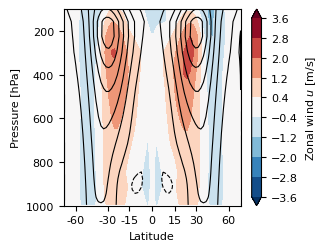

In [45]:
cm = 1/2.54  # centimeters in inches
plt.figure(figsize=(8.3*cm, 6.5*cm))
plt.subplot(111)

#fig = plt.figure(figsize=(2 + 3.5 * np.ceil(num_exp / 2.0), 7/2))
#plt.suptitle('%s\n%s' % (data_ctl.model, variable), x=0.01, ha='left')
#    for i in range(num_exp):
#plt.subplot(2, np.ceil(num_exp / 2.0), i + 1)
#plt.title("contours: %s\nshading: %s minus %s" % (data_ctl.case, data_pert[i].case, data_ctl.case), fontsize=10)

plt.contourf(sin_lat, plev, unit_conv * (data_pert[0][variable].values - data_ctl[variable].values), cons_diff, cmap="RdBu_r", extend="both")

cb = plt.colorbar()
cb.set_label("Zonal wind $u$ [" + unit_name + "]")
cb.set_ticks(cons_diff)

plt.contour(sin_lat, plev, unit_conv * data_ctl[variable].values, cons, colors="k", linewidths=0.8)
#plt.ylim([1000, 0])
plt.ylim([1000, 100])
plt.xticks(np.sin(np.deg2rad(plot_xticks)), plot_xticks)
plt.xlabel("Latitude")
plt.ylabel("Pressure [hPa]")

plt.tight_layout()

plt.savefig(os.path.join(fig_dir, "fig08.eps"))

## Figure 7

In [46]:
vn = imload.define_variable_names()

In [47]:
model_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]

experiment_list = [
    "itcz-SST",
    "itcz-slab",
    "itcz-slab-m40",
    "itcz-slab-m20",
    "itcz-slab-p20",
    "itcz-slab-p40"
]

exp_ctl_list = experiment_list[1:6]

data = {}
for model in model_list:
    data[model] = imload.load_data(model, experiment_list)

/Users/agp93/Documents/github/width-itcz-mip/itczmip/load.py:23: UserWarning: rename 'lat' to 'lat' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_exp = data_exp.rename(dim_dict[model])


#### Compute some derived variables for all models/experiments

In [48]:
for model in model_list:
    for exp, ds in data[model].items():
        imcompute.calc_derived_vars(model, ds)
        imcompute.calc_surf_TOA_fluxes(model, ds)

### Plot latitude versus pressure response to q-flux perturbations

In [49]:
variable = "psi"

#model_plot_list = ["GFDL-AM2", "CESM1", "CESM2", "CESM2-QOBS","Isca"]
model_plot_list = ["GFDL-AM2", "CESM1", "CESM2", "Isca"]

exp_plot_ctl = exp_ctl_list[0]
exp_plot_pert_list = [exp_ctl_list[-1]]#exp_ctl_list[1:]

levels_clim = {"psi": np.arange(-225e9, 230e9, 50e9),
               "ua": np.arange(-60, 61, 10)}


levels_diff = {"psi": np.arange(-37.5e9, 38e9, 5e9),
               "ua": np.arange(-3.6, 3.7, 0.8)
              }

unit_name=""

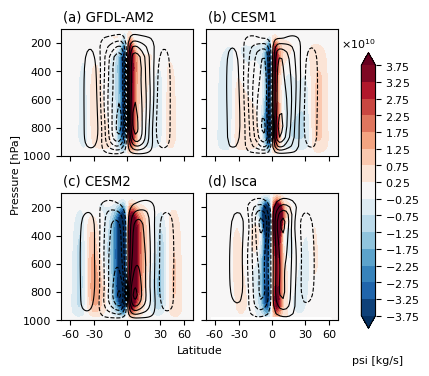

In [110]:
cm = 1/2.54  # centimeters in inches
#fig = plt.figure(figsize=(12*cm, 10*cm))
#axes =  fig.subplots(2,2,sharex=True,sharey=True)

fig, axes =  plt.subplots(2,2,sharex=True,sharey=True,figsize=(12*cm, 10*cm))#,xlabel="x-label")

axx = [0,0,1,1]
axy = [0,1,0,1]
panellabels = ['a','b','c','d']

for imodel,model in enumerate(model_plot_list):
    plt.axes(axes[axx[imodel],axy[imodel]])
    #plt.subplot(2,2,imodel+1)
    var_plot = vn[model].get(variable)
    if var_plot is None:
        var_plot = variable

    ctl_data = data[model][exp_plot_ctl]
    pert_data = [data[model][x] for x in exp_plot_pert_list]

    #     data_and_delta_latplev(
    #         ctl_data,
    #         pert_data,
    #         var_plot,
    #         cons=levels_clim[variable],
    #         cons_diff=levels_diff[variable],
    #         unit_name=unit_name
    #     )
    #     def data_and_delta_latplev(data_ctl, data_pert, variable, unit_conv=1.0, unit_name="", cons=9, cons_diff=9):
    
    data_ctl = ctl_data
    data_pert = pert_data
    unit_conv=1.0, 
    cons=levels_clim[variable]
    cons_diff=levels_diff[variable]    
    
    num_exp = len(data_pert)
    sin_lat = np.sin(np.deg2rad(data_ctl.lat.values))
    plev = data_ctl.plev.values
    plot_xticks = [-60, -30, 0, 30, 60]
    if unit_name == "":
        unit_name = data_ctl[var_plot].units
    
    i=0
    #plt.title('%s\n%s' % (data_ctl.model, var_plot), x=0.01, ha='left')
    plt.title('(%s) %s' % (panellabels[imodel],data_ctl.model), x=0.01, ha='left')
    #plt.title('%s %s' % (imodel%2,data_ctl.model), x=0.01, ha='left')

    cs = plt.contourf(sin_lat, plev, unit_conv * (data_pert[0][var_plot].values - data_ctl[var_plot].values), cons_diff, cmap="RdBu_r", extend="both")


    plt.contour(sin_lat, plev, unit_conv * data_ctl[var_plot].values, cons, colors="k", linewidths=0.8)
    #plt.ylim([1000, 0])
    #plt.ylim([1000, 100])
    plt.xticks(np.sin(np.deg2rad(plot_xticks)), plot_xticks)
    plt.ylim([1000, 100])

    #if imodel%2 == 0:
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel("Latitude")
plt.ylabel("Pressure [" + data[model][exp_plot_ctl].plev.units + "]",labelpad=10)
#fig.suptitle("contours: %s\nshading: %s minus %s" % (data[model][exp_plot_ctl].case, data[model][exp_plot_pert_list[0]].case, data[model][exp_plot_ctl].case), fontsize=10)
#plt.title("contours: %s\nshading: %s minus %s" % (data[model][exp_plot_ctl].case, data[model][exp_plot_pert_list[0]].case, data[model][exp_plot_ctl].case), fontsize=10,labelpad=10)


plt.tight_layout()

plt.text(1.05,-.15,data_ctl[var_plot].name + " [" + unit_name + "]")


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
cb = plt.colorbar(cs, cax=cbar_ax)
cb.set_ticks(cons_diff)
cb.ax.ticklabel_format(useMathText=True)


plt.savefig(os.path.join(fig_dir, "fig07.eps"))